# Practical 1

### [Carl Henrik Ek](http://carlhenrik.com), University of Cambridge

### 2022-10-27

$$
$$

::: {.cell .markdown}

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

# Sequential Decision Making

This notebook will form part of your individual submission for the
course. The notebook will roughly mimick the parts that are in the PDF
worksheet. Your task is to complete the code that is missing in the
parts below and answer the questions that we ask. The aim is not for you
to solve the worksheet but rather for you to show your understanding of
the material in the course, instead of re-running and aiming to get
“perfect” results run things, make sure it is correct and then try to
explain your results with a few sentences.

First we need to implement the surrogate model, we will use a Gaussian
process surrogate.

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import cdist

In [124]:
def f(X, noise=0.0):
    return -(-np.sin(3*X) - X**2 + 0.7*X + noise*np.random.randn(*X.shape))

def squared_exponential_computer(x1,x2,theta):
    # compute the squared exponential covariance function
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    K = theta[1] * np.exp(-np.power(d,2)/theta[0])
    if x2 is None:
      row, col = np.diag_indices_from(K)
      K[row, col] += 1e-6   # avoid negative variance
    return K

def gpposterior(x_star,X,Y,theta):
    # return the posterior estimate of the GP
    k_starX = squared_exponential_computer(x_star, X, theta)
    k_xx = squared_exponential_computer(X, None, theta)
    k_starstar = squared_exponential_computer(x_star, None, theta)

    mu = k_starX @ (np.linalg.inv(k_xx)) @ Y
    sigma = k_starstar - (k_starX) @ (np.linalg.inv(k_xx)) @ k_starX.T
    return mu, sigma

theta = np.zeros((2, ))
theta[0] = 0.3  # lengthscale
theta[1] = 1.0; # variance

When we have the surrogate model up and running we need to implement the
acquisition function.

In [125]:
def expected_improvement(f_star, mu, varSigma):
    # return the value of the acquisition function at each
    imp = f_star - mu
    Z = imp / varSigma
    exi = imp * norm.cdf(Z) + varSigma * norm.pdf(Z)
    return exi

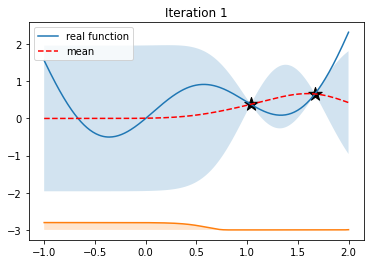

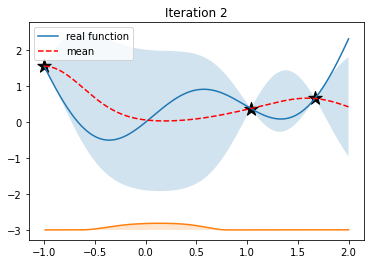

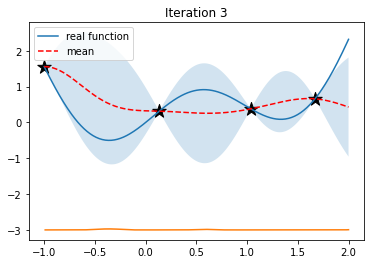

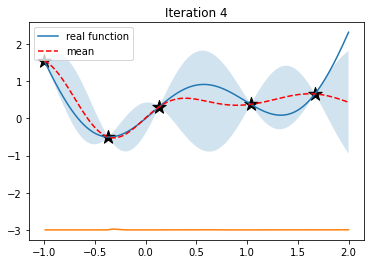

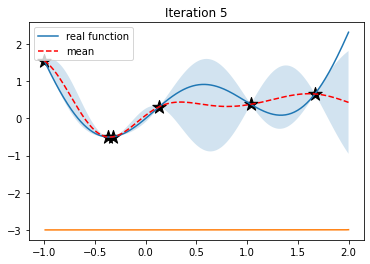

In [126]:
def plot_real_function(ax, x_star, y_star):
    # plot the real function
    ax.plot(x_star, y_star, label="real function")


def plot_posterior_function(ax, x_star, mu_star, var_star):
    # plot the mean and variance for gaussian process
    uncertainty = 1.96 * np.sqrt(np.diag(var_star))
    ax.plot(x_star, mu_star, "r--", label="mean")
    ax.fill_between(x_star.flatten(), mu_star + uncertainty, mu_star - uncertainty, alpha=0.2)

def plot_expected_improvement(ax, x_star, exi):
    # plot the expected improvent function
    ax.plot(x_star, exi - 3)  # move the plot down 3 units
    ax.fill_between(x_star.flatten(), exi - 3, -3, alpha=0.2)

theta[0] = 0.3
theta[1] = 1.0
np.random.seed(42)
num = 300
x_star = np.linspace(-1, 2, num) # set for gaussian process    
index = np.random.permutation(num)       
X = x_star[index[0:2]]
f_star = min(f(x_star))

x_remain_index = np.delete(np.arange(num), index[0:2]) # index of points that haven't been evaluated

for i in range(5):
    y_star = f(x_star)

    x_star = np.reshape(x_star, (-1, 1))

    Y = f(X)
    X = np.reshape(X, (-1, 1))
    Y = np.reshape(Y, (-1, 1))

    mu_star, var_star = gpposterior(x_star, X, Y, theta)
    mu_star = mu_star.flatten()

    # print the gaussian process and bayesian optimization
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Iteration {}".format(i + 1))
    plot_real_function(ax, x_star, y_star)
    plot_posterior_function(ax, x_star, mu_star, var_star)
    ax.scatter(X, Y, 200, 'k', '*', zorder=2)
    diag_var = np.diagonal(var_star)
    exi = expected_improvement(f_star, mu_star[x_remain_index], diag_var[x_remain_index])
    plot_expected_improvement(ax, x_star[x_remain_index], exi)
    plt.legend()
    plt.show()

    
    ind = x_remain_index[np.argmax(exi)]

    X = np.append(X, x_star[ind])
    x_remain_index = np.delete(x_remain_index, np.where(x_remain_index == ind))
    if f_star > f(x_star[ind]):
        f_star = f(x_star[ind])

Once you have the above code up and running you should be able to
reproduce the results that are in Figure 1 in the worksheet. Now lets
try to run some additional experiments. First lets evaluate the effect
of the initial start locations. Create a plot where on the x-axis have
the number of times you have evaluated the true function and on the
y-axis have the current minima, run the optimisation loop several times
and plot the mean and two standard deviations for the minimal value at
each iteration.

### Exercise 1

implement a loop that tries a set of random-restarts

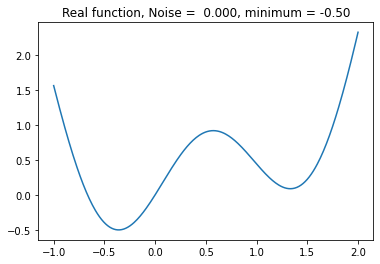

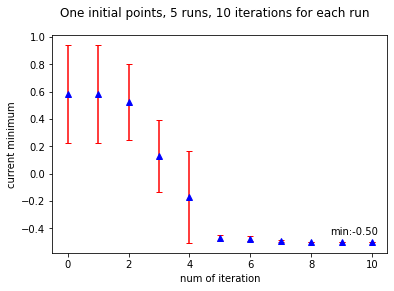

In [127]:
# Write your answer to Exercise 1 here


def bayesian_optimization(n_evals, X, Y, x_star, y_star, x_remain_index, theta, f_star, f_star_each_start):
  # run bayesian optimization with n_evals iterations
  for k in range(n_evals):
      X = X.reshape(-1, 1)
      Y = Y.reshape(-1, 1)
      mu_star, var_star = gpposterior(x_star, X, Y, theta)
      mu_star = mu_star.flatten()
      diag_var = np.diagonal(var_star)
      exi = expected_improvement(f_star, mu_star[x_remain_index], diag_var[x_remain_index])
      ind = x_remain_index[np.argmax(exi)]
      X = np.append(X, x_star[ind])
      Y = np.append(Y, y_star[ind])
      x_remain_index = np.delete(x_remain_index, np.where(x_remain_index == ind))
      
      if f_star > y_star.flatten()[ind]:
        f_star = y_star.flatten()[ind]
      f_star_each_start[k + 1] = f_star
  return f_star_each_start, X, Y, x_remain_index, mu_star, var_star


def draw_mean_and_std_dev(ax, data):
  # draw the mean and standard deviation for several runs of a bayesian optimization
  mean = np.mean(data, axis = 0)
  std = np.std(data, axis = 0)
  ax.errorbar(np.arange(len(mean)), mean, std, linestyle='None', marker='^', color="r", mfc='b', mec='b', capsize=3)
  ax.text(0.9, 0.1, "min:{:.2f}".format(mean[-1]), horizontalalignment='center',
    verticalalignment='center', transform=ax.transAxes)
  ax.set_xlabel("num of iteration")
  ax.set_ylabel("current minimum")

theta[0] = 0.3
theta[1] = 1.0
np.random.seed(42)
n_runs = 5
n_evals = 10
num = 300
noise = 0
x_star = np.linspace(-1, 2, num)
x_star = x_star.reshape(-1,1)
y_star = f(x_star, noise)

# print the true function
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Real function, Noise =  {:.3f}, minimum = {:.2f}".format(noise, min(y_star)[0]))
ax.plot(x_star, y_star, label = "true_function")
plt.show()


f_star_all = np.zeros((n_runs, n_evals + 1))
for j in range(0, n_runs):
    index = np.random.permutation(num)
    X = x_star[index[0:1]]
    Y = y_star[index[0:1]]
    x_remain_index = np.delete(np.arange(num), index[0:1]) 
    f_star = min(Y.flatten())
    f_star_each_start = np.zeros(n_evals + 1)
    f_star_each_start[0] = f_star
    f_star_each_start =  bayesian_optimization(n_evals, X, Y, x_star, y_star, x_remain_index, theta, f_star, f_star_each_start)[0]
    f_star_all[j] = f_star_each_start

fig = plt.figure()
fig.suptitle("One initial points, {} runs, {} iterations for each run".format(n_runs, n_evals))
ax = fig.add_subplot(111)
draw_mean_and_std_dev(ax, f_star_all)
plt.show()





#### Answer:
In the above case, the number of initial points is fixed (the number is 1). In the first few iterations of bayesian optimization, one can find that the standard deviation is relatively large. This is because the gaussian process will generate different surrogate functions based on different observed data, which will therefore affect the bayesian optimization's searching path toward the minimum. Also, the mean decreases through each iteration, because whatever the searching path, bayesian optimization can optimize the current minimum value given an appropriate surrogate function. 

However, in the last few iterations, the mean remains stable and close to the optimal minimum, and the standard deviation is small. This is because the gaussian process can have more comprehensive information (more points) after each iteration, which makes it informative enough to generate a good surrogate function that is close to the real function. This informative surrogate function helps bayesian optimization to find the optimal result finally.

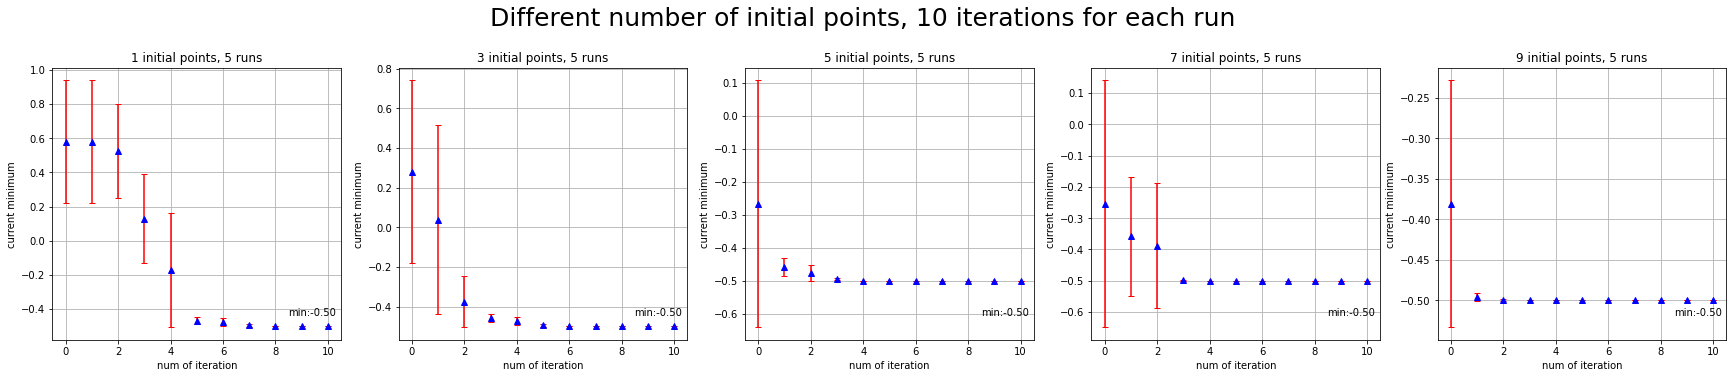

In [128]:
# input prior size is differnt
np.random.seed(42)

theta[0] = 0.3
theta[1] = 1.0
n_runs = 5
n_evals = 10
num = 300
noise = 0
x_star = np.linspace(-1, 2, num) # index set for gaussian process    
x_star = x_star.reshape(-1,1)
y_star = f(x_star, noise)

fig = plt.figure(figsize = (30,5))
fig.suptitle("Different number of initial points, {} iterations for each run".format(n_evals), size = 25, y = 1.05)

for i in range(0, 5): # five different number of initial points 
  f_star_all = np.zeros((n_runs, n_evals + 1))
  for j in range(0, n_runs):
      index = np.random.permutation(num)
      X = x_star[index[0:i * 2 + 1]]
      Y = y_star[index[0:i * 2 + 1]]
      x_remain_index = np.delete(np.arange(num), index[0:i * 2 + 1]) # index of points that haven't been evaluated
      f_star = min(Y.flatten())
      f_star_each_start = np.zeros(n_evals + 1)
      f_star_each_start[0] = f_star
      f_star_each =  bayesian_optimization(n_evals, X, Y, x_star, y_star, x_remain_index, theta, f_star, f_star_each_start)[0]
      f_star_all[j] = f_star_each_start

  ax = fig.add_subplot(151 + i)
  draw_mean_and_std_dev(ax, f_star_all)
  ax.set_title("{} initial points, {} runs".format(i * 2 + 1, n_runs))    
  plt.grid()
plt.show()


{Explain why the plots looks this way? Does it make a difference how
many initial points you start with?}


#### Answer:
As one can find through the above plots, when the bayesian optimization starts with a larger number of initial points, the algorithm tends to approach the minimum value faster. This is reasonable because when the gaussian process has more observed data, it will have more information about the property of the real function. Therefore, with more initial points, the gaussian process can generate a better surrogate function that facilitates bayesian optimization. 

### Exercise 2

While the function have a local minima so it presents some challenges
for optimisation it is still quite easy to find the minima. Let us try
make the function a bit more challenging by adding a bit of noise to the
function.

Implement an additional loop around the previous two loops which alters
the amount of noise added.

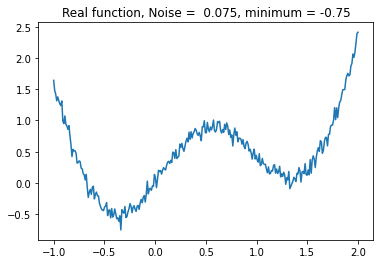

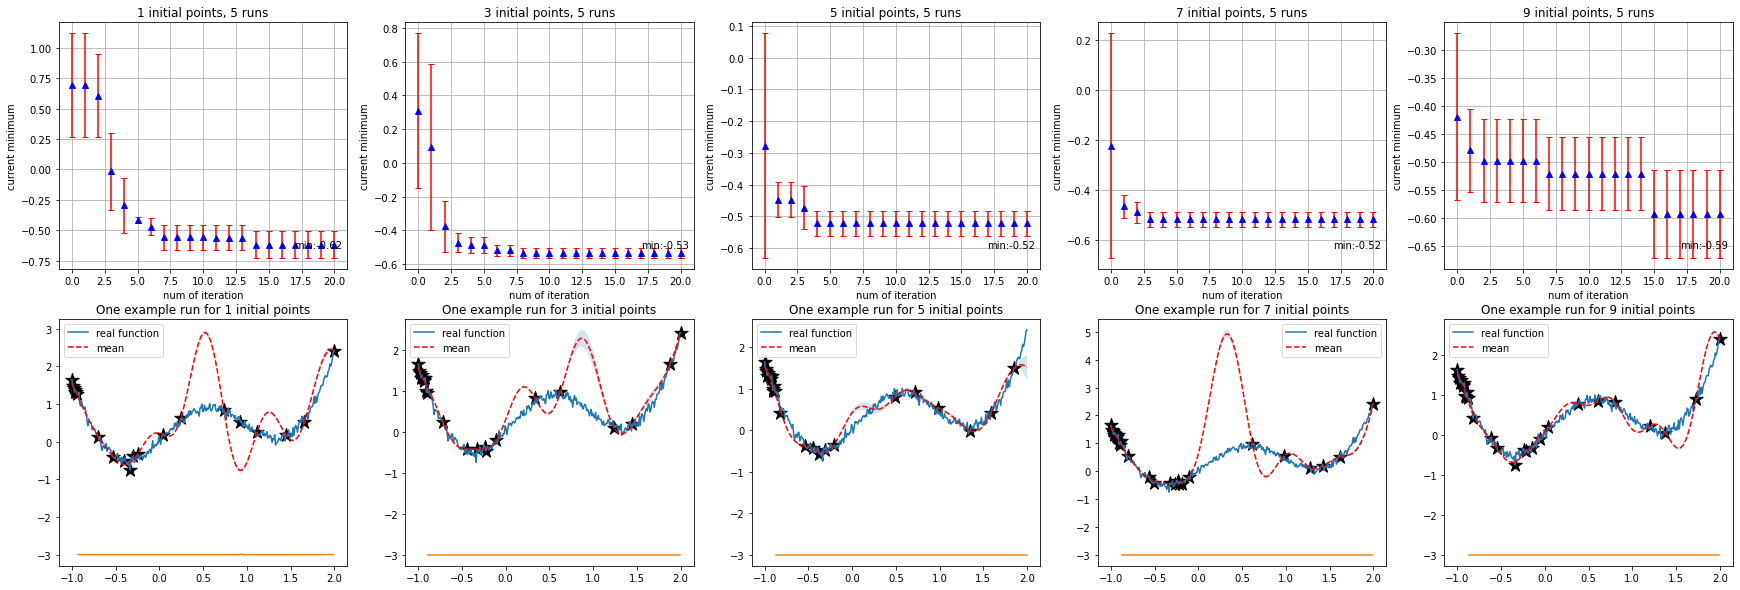

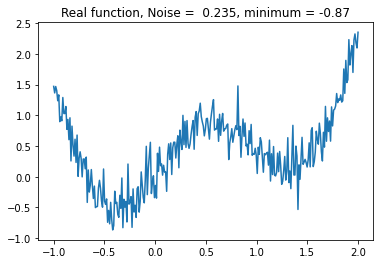

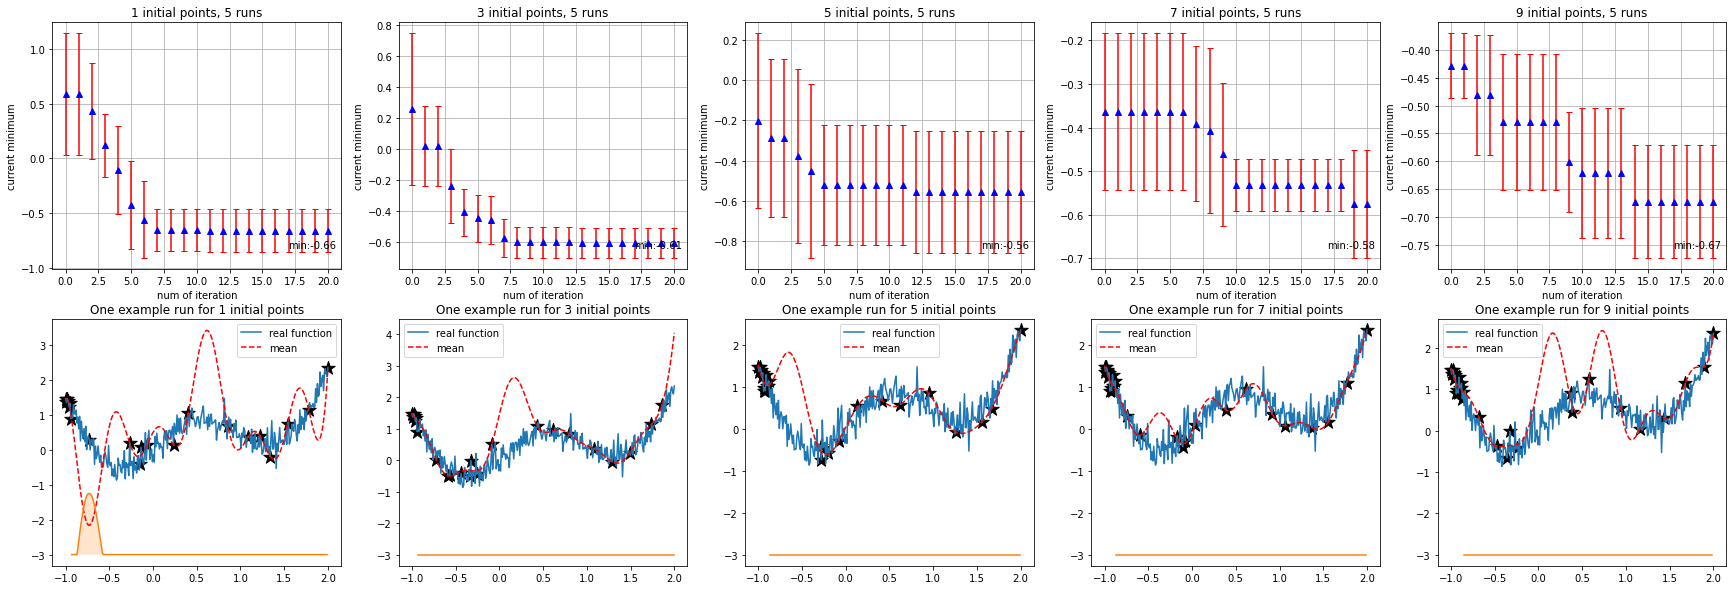

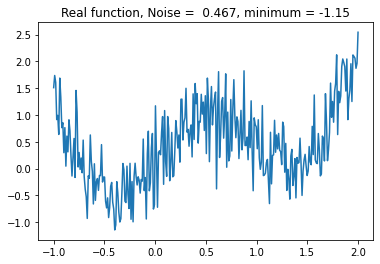

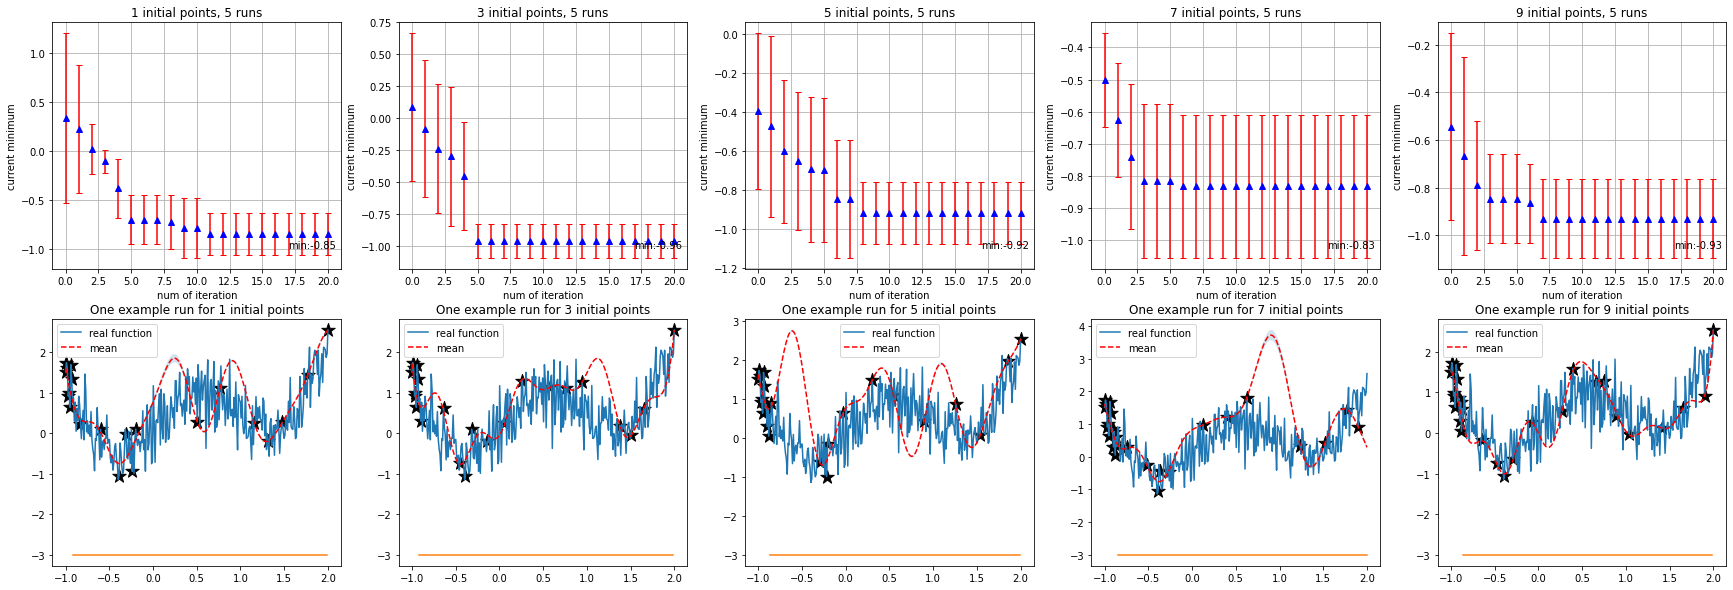

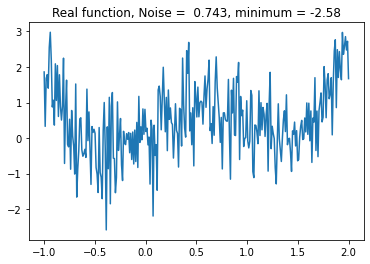

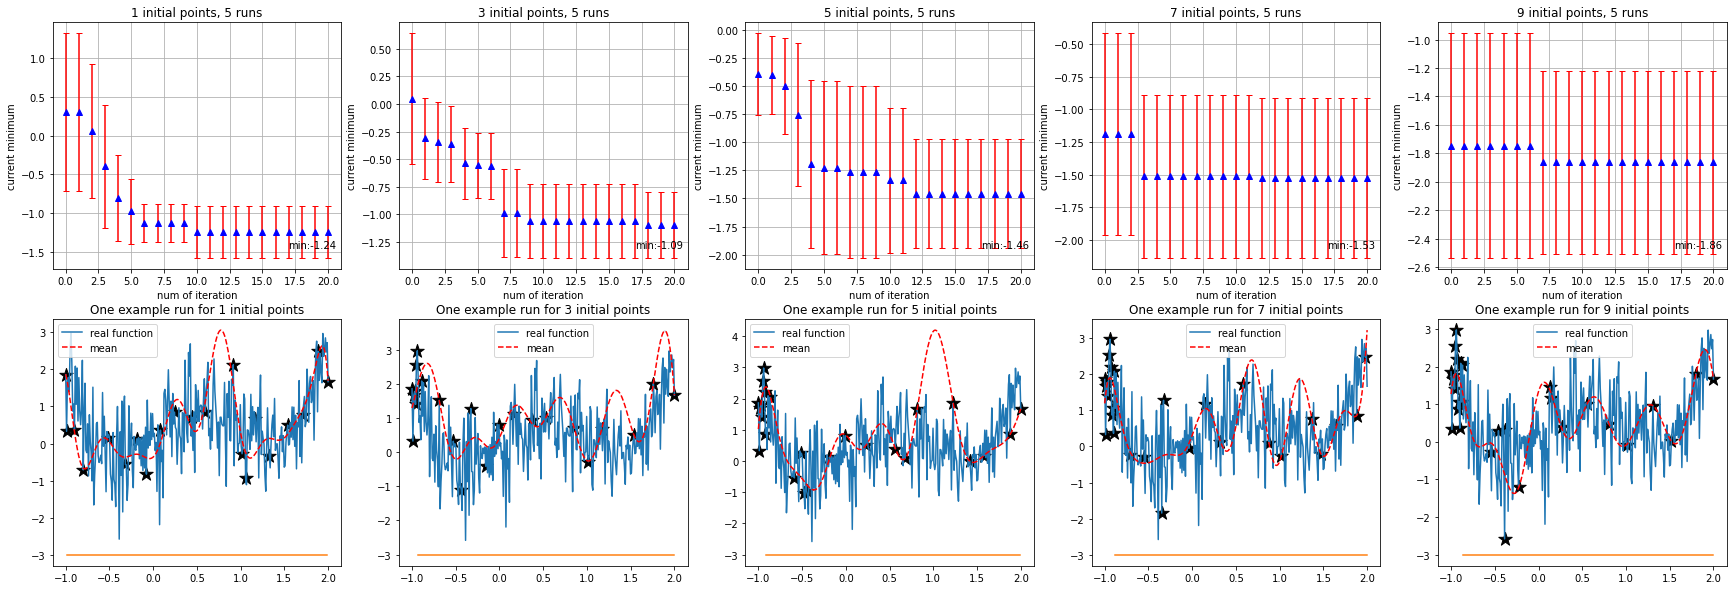

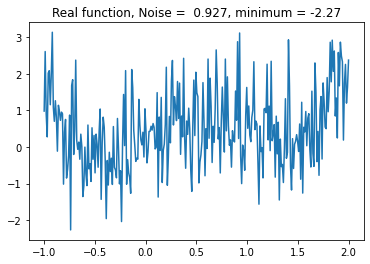

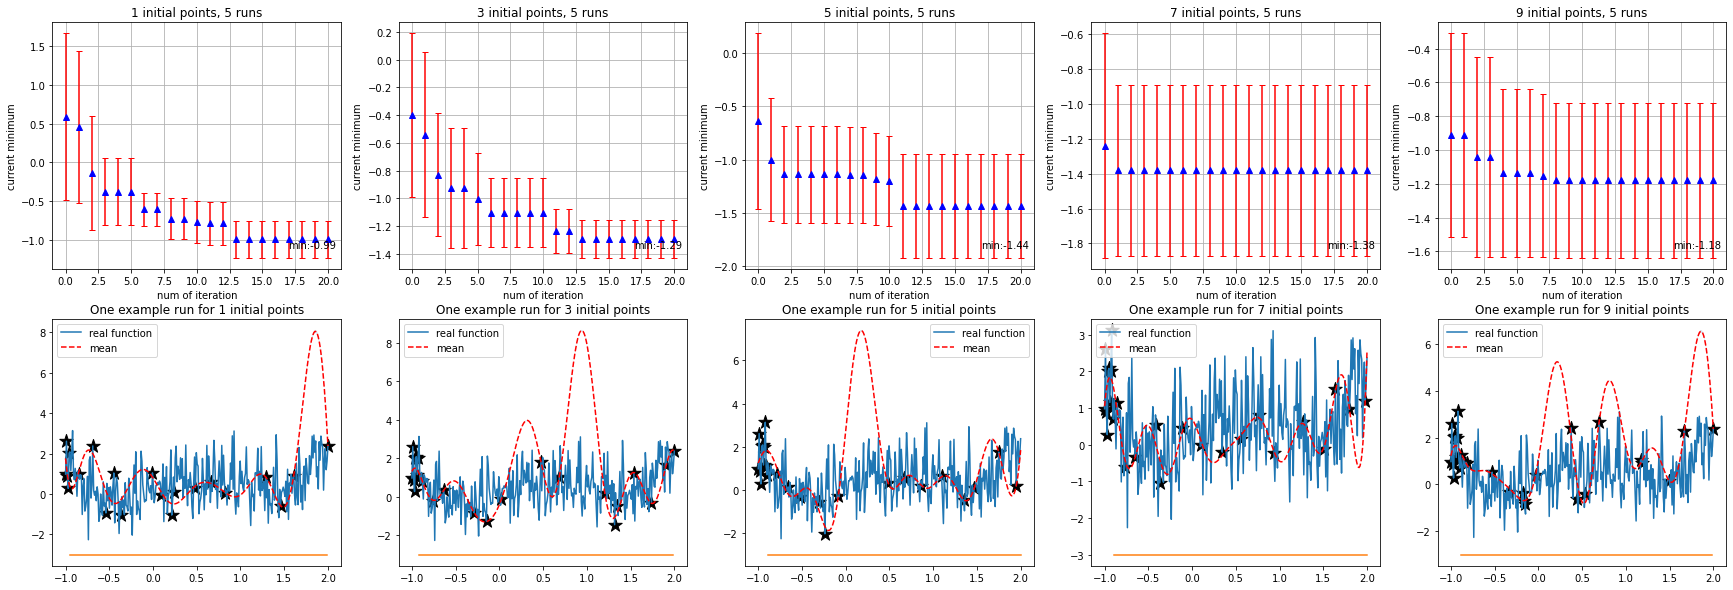

In [129]:
# Write your answer to Exercise 2 here
np.random.seed(42)

theta[0] = 0.3
theta[1] = 1.0
n_runs = 5
n_evals = 10
num = 300
n_noise = 5

for i in range(0, n_noise):
    noise = np.random.uniform(i * 0.2, (i + 1) * 0.2)
    n_runs = 5
    n_evals = 20
    num = 300
    x_star = np.linspace(-1, 2, num).reshape(-1,1)
    y_star = f(x_star, noise)

    # plot the real function
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Real function, Noise =  {:.3f}, minimum = {:.2f}".format(noise, min(y_star)[0]))
    ax.plot(x_star, y_star, label = "true_function")
    plt.show()

    fig = plt.figure(figsize = (30,10))
    for j in range(0, 5):
      f_star_all = np.zeros((n_runs, n_evals + 1))
      for k in range(0, n_runs):
        index = np.random.permutation(num)
        X = x_star[index[0:j * 2 + 1]]
        Y = y_star[index[0:j * 2 + 1]]
        x_remain_index = np.delete(np.arange(num), index[0:j * 2 + 1])
        f_star = min(Y.flatten())
        f_star_each_start = np.zeros(n_evals + 1)
        f_star_each_start[0] = f_star
        f_star_each_start, X, Y, x_remain_index, mu_star, var_star =  bayesian_optimization(n_evals, X, Y, x_star, y_star, x_remain_index, theta, f_star, f_star_each_start)
        f_star_all[k] = f_star_each_start

        if k == 0:
          # plot the result of gaussian process of first run for each number of initial points
          ax = fig.add_subplot(2,5,6 + j)
          ax.set_title("One example run for {} initial points".format(j * 2 + 1))
          plot_real_function(ax, x_star, y_star)
          plot_posterior_function(ax, x_star, mu_star, var_star)
          ax.scatter(X, Y, 200, 'k', '*', zorder=2)
          diag_var = np.diagonal(var_star)
          exi = expected_improvement(f_star_each_start[-1], mu_star[x_remain_index], diag_var[x_remain_index])
          plot_expected_improvement(ax, x_star[x_remain_index], exi)
          plt.legend()
      
      # plot mean and standard deviation for several runs of a bayesian optimization for each number of initial points
      ax = fig.add_subplot(251 + j)
      draw_mean_and_std_dev(ax, f_star_all)
      ax.set_title("{} initial points, {} runs".format(j * 2 + 1, n_runs))    
      plt.grid()

    
    plt.show()





Explain the results by contrasting to the previous none-noisy evaluation. How does the “best” run compare to the “best” run in the previous example?

#### Answer
As one can find in the above plots, even if the number of iterations for each run of the bayesian optimization is large (in the above case the number is 20), it is still hard for the algorithm to find the global minimum regardless of the number of initial points. All the plots in the last few iterations have the same mean and standard deviation of 5 runs, which implies that the current minimum in each run remains unchanged and the optimization algorithm is stuck in the local minimum. This is because the gaussian process used here has inappropriate prior knowledge: the real function is highly frequent, yet the prior (RBF kernel) encoded assumes the real function to be smooth. This makes the gaussian process generate a surrogate function without the property of high frequency, which is far from the real function. Therefore, it is hard for the bayesian optimization to be efficient if the surrogate function is improper. In addition, one can find that the standard deviation increases if the number of initial points increases. This shows that the gaussian process generates very different surrogate functions for each run with more initial points. This unstableness is undesirable.

In contrast, in the previous example without noise, the knowledge encoded in the prior of the gaussian process matches the property of the smoothness of the real function, thus generating an appropriate surrogate function and facilitating the bayesian optimization to find the optimal. Each run is the best "run" if the prior encodes correct knowledge; in contrast, without correct prior, all runs are samely bad.



### Exercise 3


### Exercise 3 Answer

Write your answer to Exercise 3 here

As you have probably noticed the kernel-hyperparmeters have a huge
effect on the results. This is a desirable effect as this is where we
encode our knowledge of the function. We will now do one experiment
where we will alter the lengthscale value and see how it effects the
results.

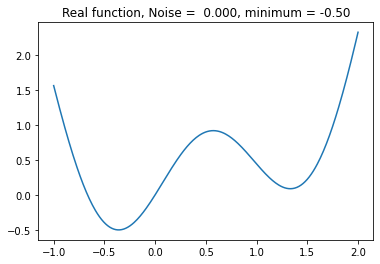

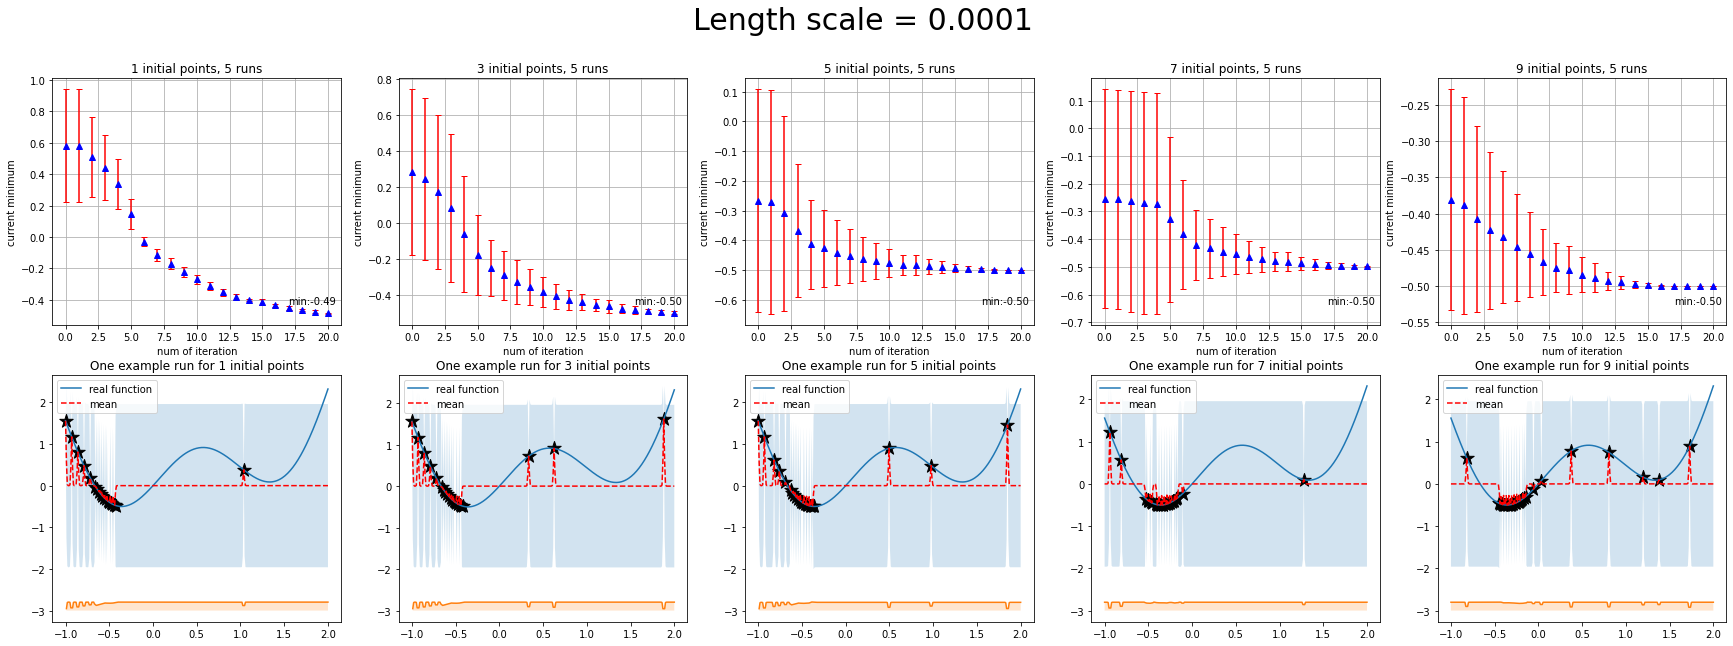

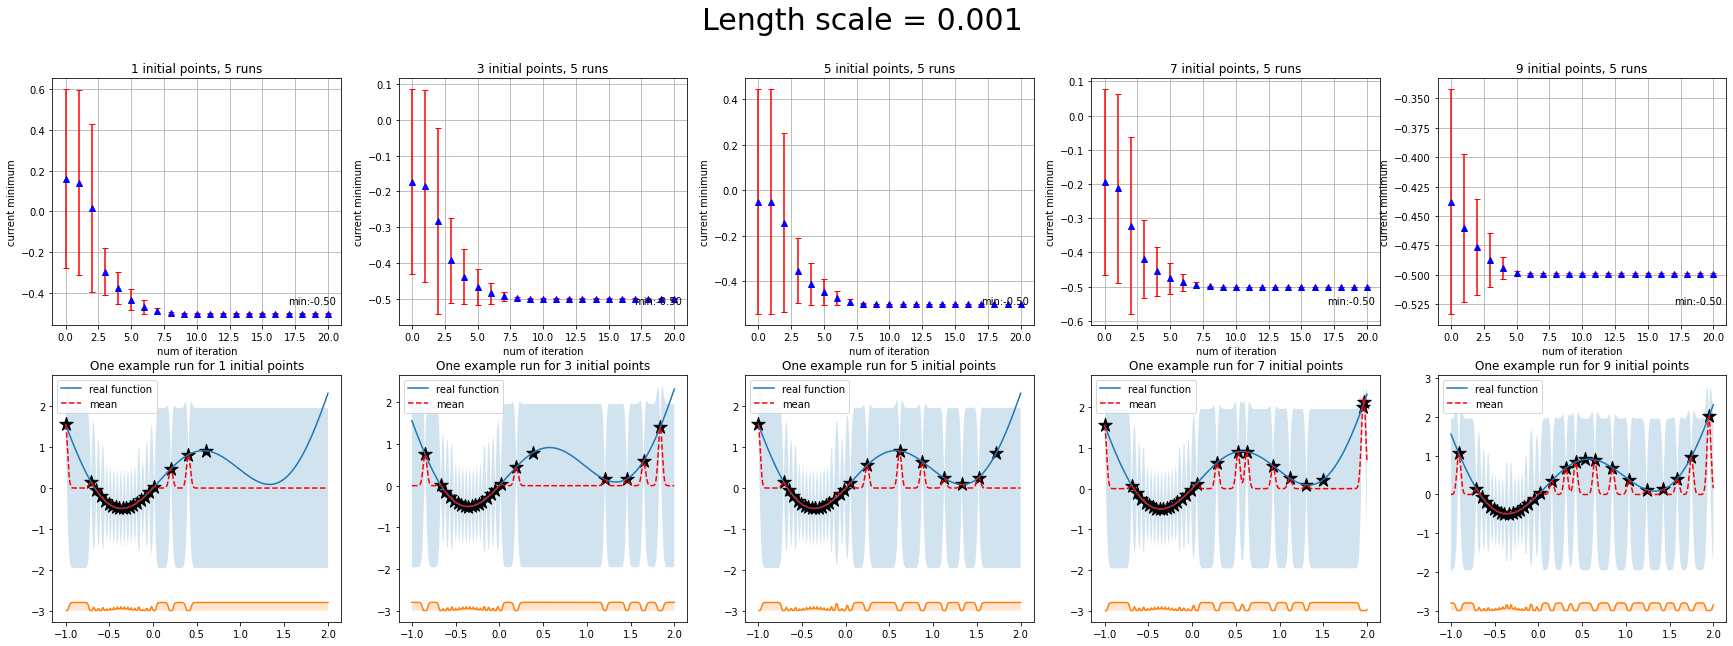

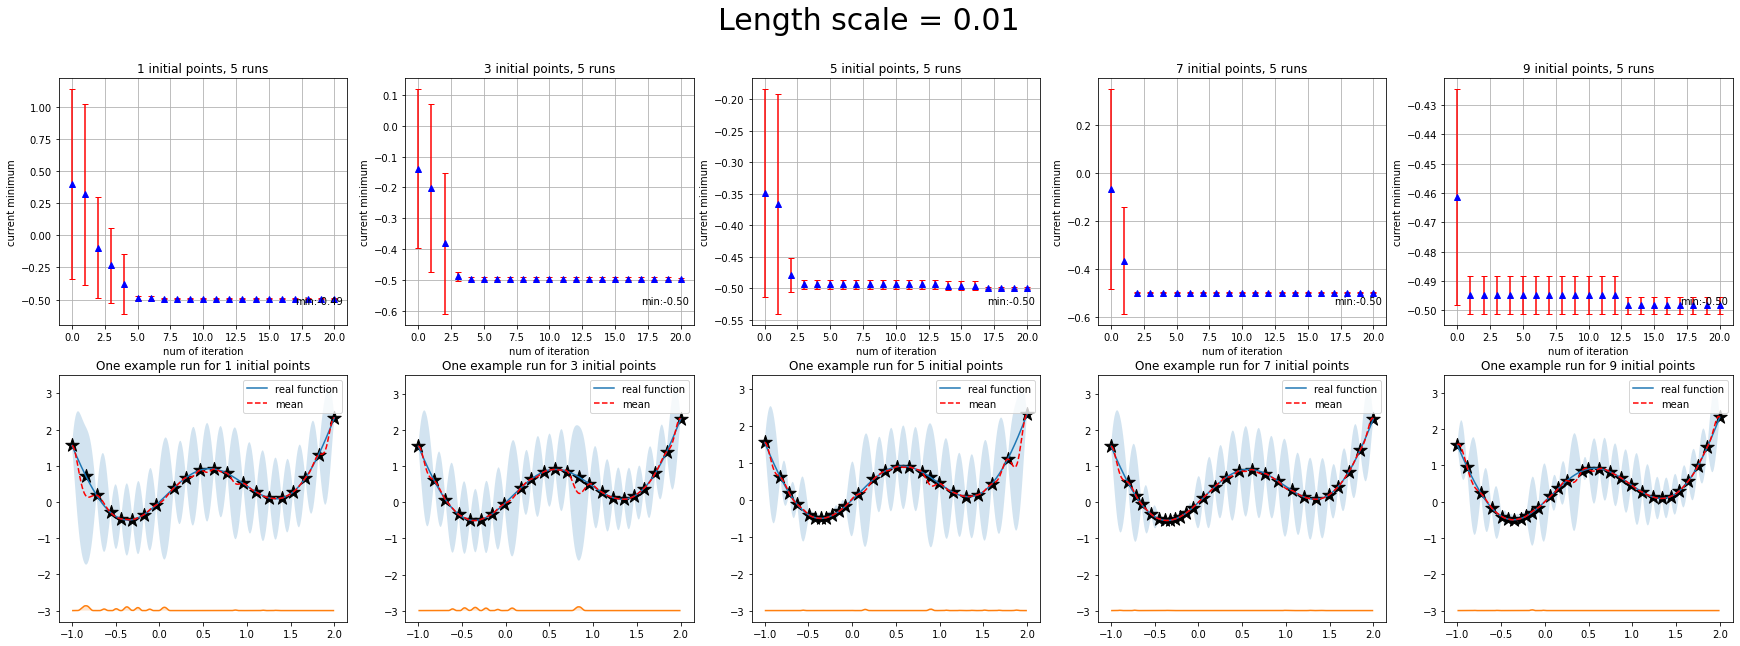

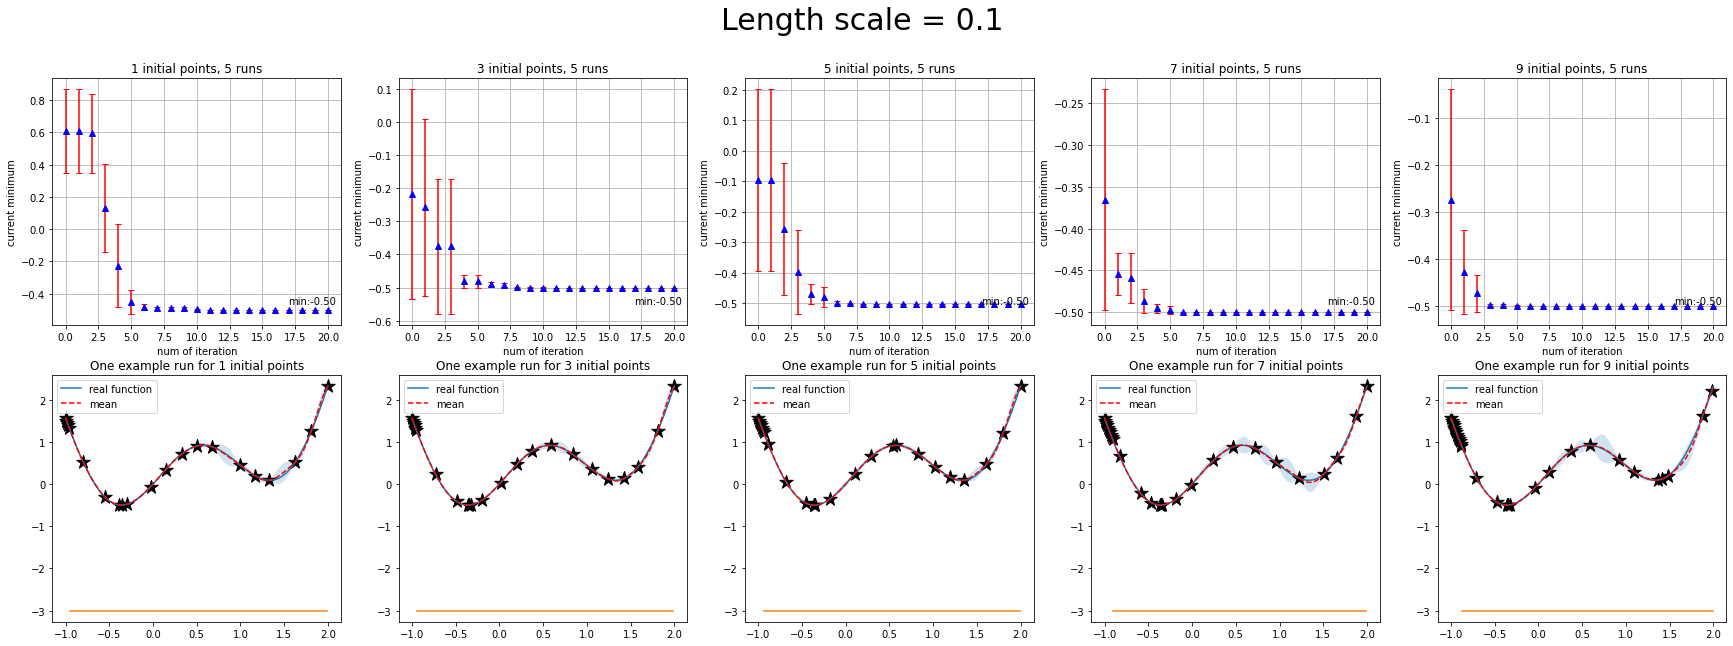

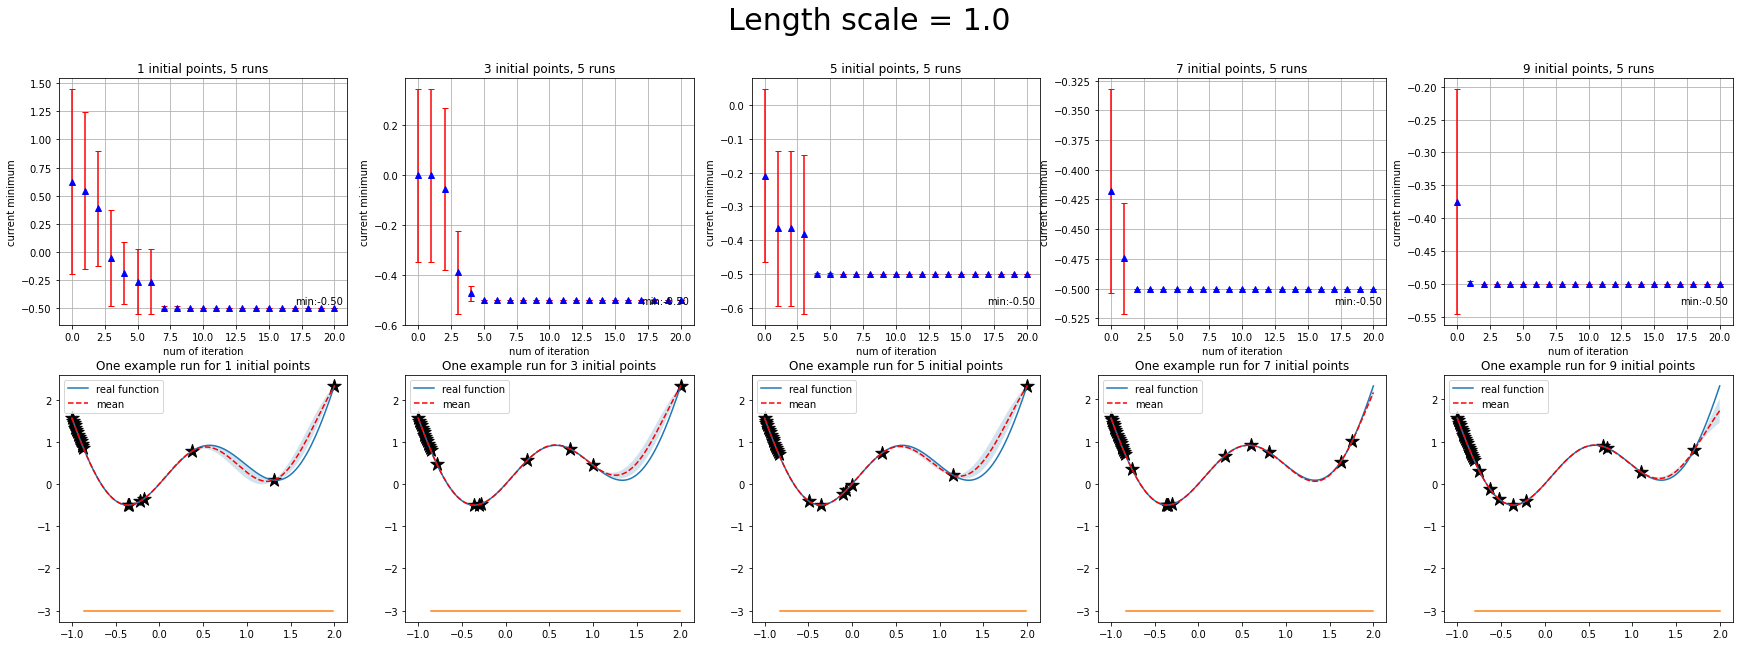

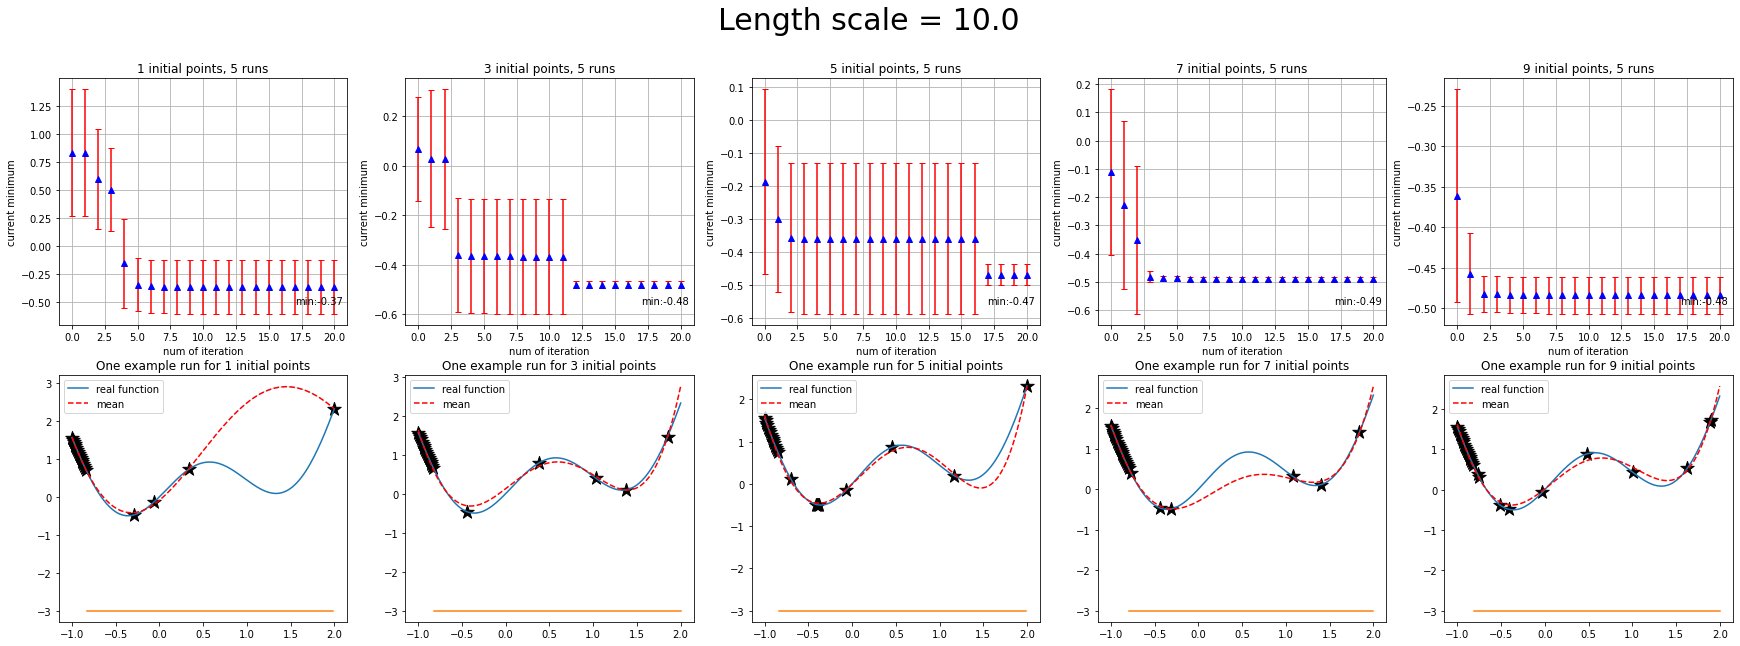

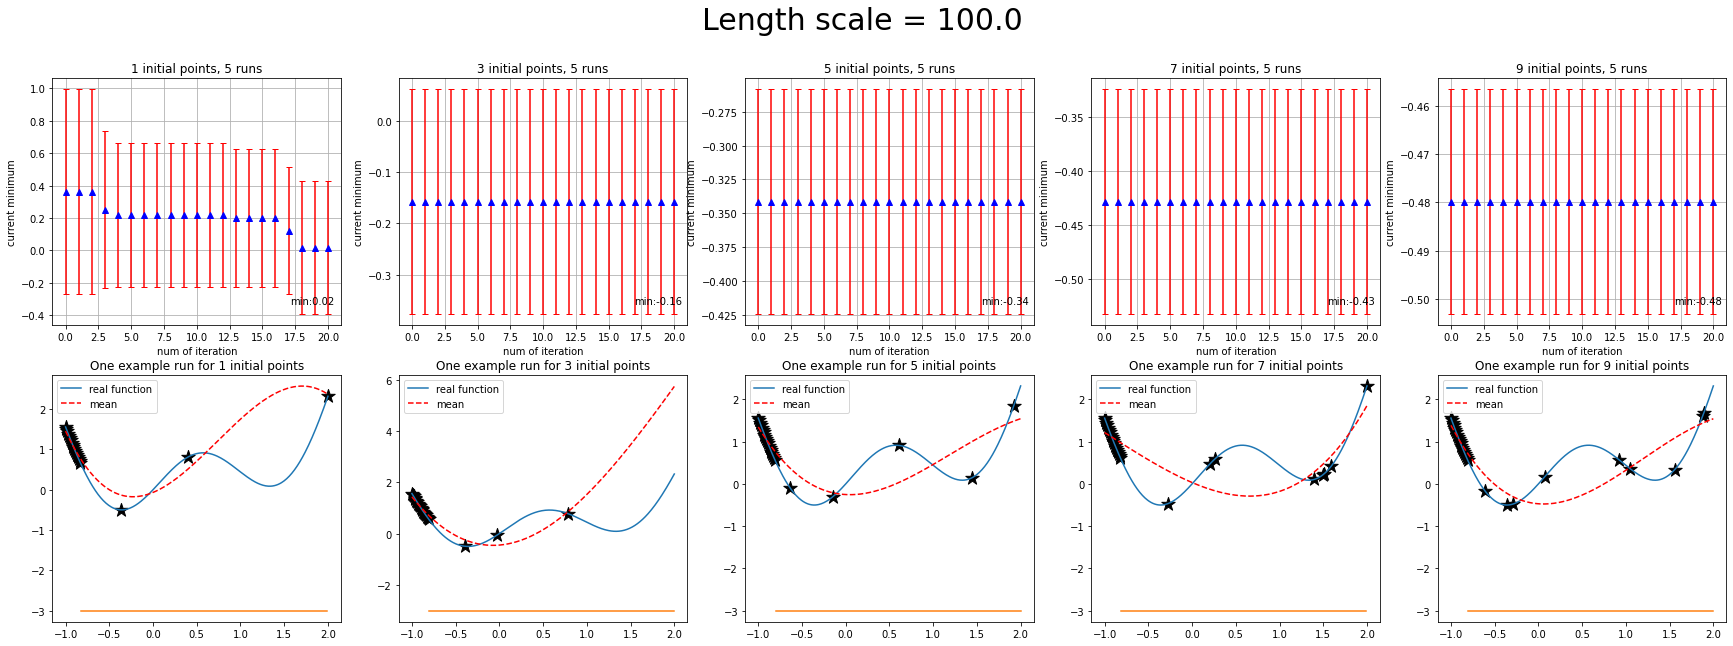

In [130]:
# implement a loop that tries different lengthScale
theta[1] = 1.0
np.random.seed(42)
n_runs = 5
n_evals = 20
num = 300
lengthScales = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
noise = 0
x_star = np.linspace(-1, 2, num).reshape(-1,1)
y_star = f(x_star, noise)

# plot the real function
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Real function, Noise =  {:.3f}, minimum = {:.2f}".format(noise, min(y_star)[0]))
ax.plot(x_star, y_star, label = "true_function")
plt.show()

for i in range(0, len(lengthScales)):
    theta[0] = lengthScales[i]
    fig = plt.figure(figsize = (30,10))
    fig.suptitle("Length scale = {}".format(theta[0]), size = 30)
    for j in range(0, 5):
      f_star_all = np.zeros((n_runs, n_evals + 1))
      for k in range(0, n_runs):
        index = np.random.permutation(num)
        X = x_star[index[0:j * 2 + 1]]
        Y = y_star[index[0:j * 2 + 1]]
        x_remain_index = np.delete(np.arange(num), index[0:j * 2 + 1]) # index of points that haven't been evaluated
        f_star = min(Y.flatten())
        f_star_each_start = np.zeros(n_evals + 1)
        f_star_each_start[0] = f_star
        f_star_each_start, X, Y, x_remain_index, mu_star, var_star =  bayesian_optimization(n_evals, X, Y, x_star, y_star, x_remain_index, theta, f_star, f_star_each_start)
        f_star_all[k] = f_star_each_start

        # plot the result of gaussian process of first run for each number of initial points
        if k == 0:
          ax = fig.add_subplot(2,5,6 + j)
          ax.set_title("One example run for {} initial points".format(j * 2 + 1))
          plot_real_function(ax, x_star, y_star)
          plot_posterior_function(ax, x_star, mu_star, var_star)
          ax.scatter(X, Y, 200, 'k', '*', zorder=2)
          diag_var = np.diagonal(var_star)
          exi = expected_improvement(f_star_each_start[-1], mu_star[x_remain_index], diag_var[x_remain_index])
          plot_expected_improvement(ax, x_star[x_remain_index], exi)
          plt.legend()
      
      # plot mean and standard deviation for several runs of a bayesian optimization for each number of initial points
      ax = fig.add_subplot(251 + j)
      draw_mean_and_std_dev(ax, f_star_all)
      ax.set_title("{} initial points, {} runs".format(j * 2 + 1, n_runs))    
      plt.grid()
    plt.show()

Explain the results and why you see the specific effect? You might want to increase the `n_evals` a little bit compared to your previous experiment. You can also implement a criteria to leave the inner-loop based on how large your improvement is over a set number of iterations. As you probably notice the effect of the hyper-parameters is quite significant. Explain how you think we should approach a problem where we are uncertain about the hyper-parameters?

#### Answer:
When the length scale is very small (length scale = 0.0001), each sampled variable in the gaussian process hardly changes the mean and the standard deviation of the nearby variables. This is because the covariance between two variables is tiny given a tiny length scale, even if the two variables are close to each other. Therefore, variables that are not sampled remain their original mean and variance. In contrast, when the length scale is very large (length scale = 100), each sampled variable has a significant effect on nearby variables as the covariance between them is large.

Another finding is that bayesian optimization generally works better when the length scale is small rather than large, even if both small and large length scales make the gaussian process generate a bad surrogate function. This is because, as one can find on the plots, bayesian optimization can slowly reduce the current minimum with each iteration when the length scale is small, but stuck in the local minimum when the length scale is large. This inspires us to start with a relatively small length scale when we are uncertain, and slowly increase the length scale. Another choice can be using the dichotomy which starts with the left-hand side taking a small value and the right-hand side taking a length scale that is not too large. 

## Extra

For a final extra experiment try to fit the kernel parameters inside the
inner-loop. The way to do this is to maximise the marginal likelihood of
the surrogate model using gradient descent. You can alter the numpy code
that we have implemented to jax instead and which will allow you to use
auto-differetiation to compute gradients. Now you can implement a simple
gradient descent

In [131]:
from jax import grad
import jax.numpy as jnp

In [132]:
def squared_exponential(x1, x2, theta):
    # theta[0] - variance
    # theta[1] - lengthscale
    if x2 == None:
        return theta[0]*jnp.exp(-cdist(x1, x1, metric='sqeuclidean')/theta[1]**2)
    else:
        return theta[0]*jnp.exp(-cdist(x1, x2, metric='sqeuclidean')/theta[1]**2)

def logmarginal_likelihood(x, y, theta):
    # implement the log-marginal likelihood of a GP
    
dLdtheta = grad(logmarginal_likelihood, argnums=2)
for i in range(1000):
    
    theta -= dLdtheta(w) * 0.01

IndentationError: ignored

# Submission

You can submit the notebook on Moodle. Name your notebook using your
CRSid as `crsid_practical-one.ipynb` before submitting to Moodle.

The deadline for the submission is Friday the 4th of November at 23:59.